In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Imports
import torch
import torch.nn as nn
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

In [5]:
from vae import VAE
from vae import GroupSoftmax
from trainer import Trainer

In [6]:
# Device config 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
#data_name = 'one_hot_allNaNs_agep.csv'
#model_name = 'model_allNaNs_agep.pth'
#
#data_name = 'one_hot_allNaNs_agep_small.csv'
#model_name = 'model_small.pth'

data_name = 'one_hot_pNaNs_agep.csv'
model_name = 'model_pNaNs_agep.pth'


In [8]:
# load data 
data = pd.read_csv(f'/workspace/data/{data_name}')
data_tensor = torch.tensor(data.values, dtype=torch.float32)
# load model 
cols = list(data.columns)
cols = [col.split(":")[0] for col in cols]

onehot_counts = {col: sum(data.columns.str.startswith(f"{col}:")) for col in cols}
group_sizes = list(onehot_counts.values())
input_size = data.shape[1]

model = VAE(input_size, 1500, 6, 500, group_sizes)
model.load_state_dict(torch.load(f'/workspace/models/{model_name}'))
model.eval()

VAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): MLPBlock(
        (layers): Sequential(
          (0): Linear(in_features=433, out_features=1500, bias=True)
          (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ResidualBlock(
        (mlp1): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_features=1500, out_features=1500, bias=True)
            (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (mlp2): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_features=1500, out_features=1500, bias=True)
            (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (2): ResidualBlock(
        (mlp1): MLPBlock(
          (layers): Sequential(
            (0): Linea

In [9]:
# sample from the model 
n_samples = len(data_tensor)

# sample from the model
sample = model.pretrain_sample(n_samples)
predicted = torch.mean(sample, dim=0).detach().cpu().numpy()

# apply the group softmax to the data
group_softmax = GroupSoftmax(group_sizes)
data_softmax = group_softmax(data_tensor)
ground_truth = torch.mean(data_softmax, dim=0).detach().cpu().numpy()

print(f'ground_truth: {ground_truth.shape}')
print(f'predicted: {predicted.shape}')


ground_truth: (433,)
predicted: (433,)


In [10]:
# prepare dicts and namings for plotting
labels = list(data.columns)
labels = [label.split(":") for label in labels]
feature_label_dict = {}
for key, label in labels:
    if key in feature_label_dict:
        feature_label_dict[key].append(label) 
    else:
        feature_label_dict[key] = [label]

indices = {}

for key, label in labels:
    if key in indices:
        indices[key].append(data.columns.get_loc(f"{key}:{label}"))
    else:
        indices[key] = [data.columns.get_loc(f"{key}:{label}")]

print(feature_label_dict)
print(indices)
#data_dict = {data.columns}

{'TEN': ['owned or mortgaged', 'rented'], 'HHL': ['english', 'spanish', 'other indo-european', 'asian and pacific island languages', 'other'], 'VEH': ['no vehicles', '1 vehicle', '2 vehicles', '3 vehicles', '4 or more vehicles'], 'HINCP': ['under 5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-35k', '35k-50k', '50k-75k', '75k-100k', '100k-150k', '150k+'], 'R65': ['no', 'yes'], 'R18': ['no', 'yes'], 'SEX_1': ['male', 'female', 'nan'], 'SEX_2': ['male', 'female', 'nan'], 'SEX_3': ['male', 'female', 'nan'], 'SEX_4': ['male', 'female', 'nan'], 'SEX_5': ['male', 'female', 'nan'], 'SEX_6': ['male', 'female', 'nan'], 'SEX_7': ['male', 'female', 'nan'], 'SEX_8': ['male', 'female', 'nan'], 'SEX_9': ['male', 'female', 'nan'], 'SEX_10': ['male', 'female', 'nan'], 'SEX_11': ['male', 'female', 'nan'], 'SEX_12': ['male', 'female', 'nan'], 'SEX_13': ['male', 'female', 'nan'], 'SEX_14': ['male', 'female', 'nan'], 'AGEP_1': ['under 5', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '

In [11]:
ten_dict = {key: [] for key in feature_label_dict['TEN']}
hhl_dict = {key: [] for key in feature_label_dict['HHL']}
veh_dict = {key: [] for key in feature_label_dict['VEH']}
hincp_dict = {key: [] for key in feature_label_dict['HINCP']}
sex_dict = {key: [] for key in feature_label_dict['SEX_1']}
education_dict = {key: [] for key in feature_label_dict['SCHL_1']}
age_dict = {key: [] for key in feature_label_dict['AGEP_1']}
r18_dict = {key: [] for key in feature_label_dict['R18']}
r65_dict = {key: [] for key in feature_label_dict['R65']}

# create dicts for the groups and their indices 
for key, labels in feature_label_dict.items():
    if 'SEX' in key:
        for idx, label in enumerate(labels):
            sex_dict[label].append(indices[key][idx])
    elif 'SCHL' in key:
        for idx, label in enumerate(labels):
            education_dict[label].append(indices[key][idx])
    elif 'AGEP' in key:
        for idx, label in enumerate(labels):
            age_dict[label].append(indices[key][idx])
    elif 'TEN' in key:
        for idx, label in enumerate(labels):
            ten_dict[label].append(indices[key][idx])
    elif 'HHL' in key:
        for idx, label in enumerate(labels):
            hhl_dict[label].append(indices[key][idx])
    elif 'VEH' in key:
        for idx, label in enumerate(labels):
            veh_dict[label].append(indices[key][idx])
    elif 'HINCP' in key:
        for idx, label in enumerate(labels):
            hincp_dict[label].append(indices[key][idx])
    elif 'R18' in key:
        for idx, label in enumerate(labels):
            r18_dict[label].append(indices[key][idx])
    elif 'R65' in key:
        for idx, label in enumerate(labels):
            r65_dict[label].append(indices[key][idx])




In [12]:
def expected_count(data, dict):
    counts = np.empty((len(dict.keys())-1,len(data)))
    for i, key in enumerate(dict.keys()):
        if key == 'nan':
            break
        for idx, row in enumerate(data):
            tmp = row[dict[key]]
            nans = row[dict['nan']]
            
            # rule out the nans equal to 1
            valid_mask = (nans != 1)
            counts[i, idx] = np.mean(tmp[valid_mask]/(1-nans[valid_mask]))
    return np.mean(counts, axis=1)


In [13]:
# rewrite the cell above into a function
def plot_group(group_name, ground_truth, predicted, label_dict, category_dict):
    fig, ax = plt.subplots()
    labels = copy.deepcopy(label_dict)
    gt_mean = expected_count(ground_truth, category_dict)
    pr_mean = expected_count(predicted, category_dict)
    # normalize 
    gt_mean /= np.sum(gt_mean)
    pr_mean /= np.sum(pr_mean)
    p_value = chisquare(gt_mean, pr_mean).pvalue
    x = np.arange(len(labels[group_name])-1) # remove nan  
    width = 0.35
    labels[group_name].remove('nan')
    keys = labels[group_name]
    ax.bar(x - width/2, gt_mean, width, label='Ground Truth')
    ax.bar(x + width/2, pr_mean, width, label='Predicted')
    ax.set_ylabel('Probability')
    ax.set_title(group_name)
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    x_max = ax.get_xlim()[1]  # Rightmost x value
    y_min, y_max = ax.get_ylim()  # Bottom and top of y-axis

    # Place p-value inside the plot area (bottom-right, but not outside the axes)
    ax.text(x_max - 0.05, y_min + (y_max - y_min) * 0.1,  # Adjusted for inside placement
            f'p-value: {p_value:.2f}', 
            fontsize=12, verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.savefig(f'/workspace/GNN_Project/plots/{group_name}.png', bbox_inches='tight')
    plt.close()

In [14]:
ground_truth = data_softmax.detach().cpu().numpy()
predicted = sample.detach().cpu().numpy()

#plot_group('TEN', ground_truth, predicted, feature_label_dict, ten_dict)
#plot_group('HHL', ground_truth, predicted, feature_label_dict, hhl_dict)
#plot_group('VEH', ground_truth, predicted, feature_label_dict, veh_dict)
#plot_group('HINCP', ground_truth, predicted, feature_label_dict, hincp_dict)
#plot_group('R18', ground_truth, predicted, feature_label_dict, r18_dict)
#plot_group('R65', ground_truth, predicted, feature_label_dict, r65_dict)

In [13]:
# plot the sex and education group without the average 
plot_group('SEX_1', ground_truth, predicted, feature_label_dict, sex_dict)
plot_group('SCHL_1', ground_truth, predicted, feature_label_dict, education_dict)
plot_group('AGEP_1', ground_truth, predicted, feature_label_dict, age_dict)

# RSME and KL

In [26]:
def rsme(gt, pred):
    sq = (gt-pred)**2
    print(sq.shape)
    mean = np.mean(sq)
    print(mean.shape)
    return np.sqrt(mean)

def kl_div(gt, pred, er):
    return np.mean((pred+er)*np.log((pred+er)/(gt+er)))

In [16]:
print(ten_dict)

{'owned or mortgaged': [0], 'rented': [1]}


In [23]:
tenList = list()

test_gt = np.flip(np.sort(ground_truth))
test_pred = np.flip(np.sort(predicted))
for key in ten_dict.keys():
    tenList += ten_dict[key]

print(tenList)
print(ground_truth[:, tenList].shape)
print(data.shape)

print(test_gt[0:5, tenList])
print(test_pred[0:5, tenList])

[0, 1]
(15256, 2)
(15256, 433)
[[0.7310586 0.7310586]
 [0.7310586 0.7310586]
 [0.7310586 0.7310586]
 [0.7310586 0.7310586]
 [0.7310586 0.7310586]]
[[0.88543653 0.8824882 ]
 [0.8862021  0.88209355]
 [0.9023356  0.89120793]
 [0.8826039  0.8820687 ]
 [0.9205435  0.91978365]]


In [18]:
print(rsme(ground_truth[:, tenList], predicted[:, tenList]))
print(kl_div(ground_truth[:, tenList], predicted[:, tenList], 1e-8))

(15256, 2)
()
0.19651228
[451.90247 866.2864 ]


In [27]:
# investigation 

t_data_tensor = data_tensor[1:2, :]
print(t_data_tensor.shape)
forward, _ , _ = model(t_data_tensor)
t_softmax = group_softmax(t_data_tensor)[:, tenList]

#print(forward)
print(torch.min(forward), torch.max(forward))
print(torch.min(t_softmax), torch.max(t_softmax))
print(rsme(t_softmax.detach().cpu().numpy(), forward.detach().cpu().numpy()[:, tenList]))
print(kl_div(t_softmax.detach().cpu().numpy(), forward.detach().cpu().numpy()[:, tenList], 1e-8))

torch.Size([1, 433])
tensor(0.0302, grad_fn=<MinBackward1>) tensor(0.8859, grad_fn=<MaxBackward1>)
tensor(0.2689) tensor(0.7311)
(1, 2)
()
0.12192719
0.017497614


In [ ]:
t_softmax = group_softmax(t_data_tensor)[:, tenList]

#print(forward)
print(torch.min(forward), torch.max(forward))
print(torch.min(t_softmax), torch.max(t_softmax))
print(rsme(t_softmax.detach().cpu().numpy(), forward.detach().cpu().numpy()))

torch.Size([15256, 500])
(15256, 2)


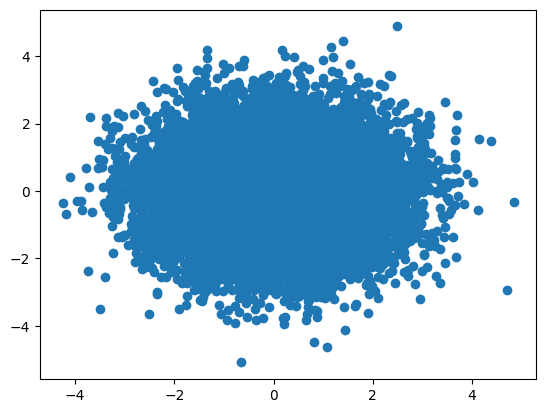

In [20]:
# check if encoded data is truly gaussian 
encoded, _, _ = model.encoder(data_tensor)
print(encoded.shape)
# apply pca to the encoded data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(encoded.detach().cpu().numpy())
pca_data = pca.transform(encoded.detach().cpu().numpy())
print(pca_data.shape)
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.show()

In [21]:
# check if the reconstruction sums up to 1 for each group
reconstruction, _, _ = model(data_tensor)

print(reconstruction.shape)

# sum over all the groups, reconstruction is already softmaxed
start = 0 
group_sums = []

for size in group_sizes:
    chunk = reconstruction[:, start:start+size]
    start += size
    group_sums.append(torch.sum(chunk, dim=1))

group_sums = torch.stack(group_sums, dim=1)
print(group_sums.shape)
print(torch.allclose(group_sums, torch.ones_like(group_sums), rtol=1e-5, atol=1e-5))

torch.Size([15256, 433])
torch.Size([15256, 48])
True
